In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *
from dispatch.dispatch import Dispatch, NeuralDispatch
from simulator.base_simulator import BaseSimulator, ManualSimulator
from simulator.simulator import Simulator
from simulator.graphics import plot_CR, plot_counts
from tqdm import tqdm
import json

import torch
from networks.encoders.point_encoder import PointEncoder
# from networks.scoring_v1 import ScoringNet, ScoringInterface

from collections import defaultdict
import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
import torch.nn.functional as F
from torchrl.collectors import SyncDataCollector, MultiaSyncDataCollector, MultiSyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from torchrl.envs import EnvBase
from tensordict.tensordict import TensorDictBase, TensorDict
from typing import Optional
import gym
from torchrl.data import CompositeSpec, BoundedTensorSpec, UnboundedContinuousTensorSpec, BinaryDiscreteTensorSpec, OneHotDiscreteTensorSpec, DiscreteTensorSpec, UnboundedDiscreteTensorSpec

from networks.scoring_networks.net1 import ScoringNet
from networks.encoders.gamble_encoder import GambleTripleEncoder
# import importlib
# importlib.reload(utils)

In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: limon8884. Use `wandb login --relogin` to force relogin


True

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

num_cells = 256  # number of cells in each layer
lr = 3e-4
max_grad_norm = 1.0

frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 200_000 // frame_skip

sub_batch_size = 4  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

cpu


In [4]:
with open('configs/network_hyperparams.json') as f:
    hyperparams = json.load(f)    

net = ScoringNet(
    n_layers=hyperparams['n_layers'],
    d_model=hyperparams['d_model'],
    n_head=hyperparams['n_head'],
    dim_ff=hyperparams['dim_ff'],
    device=device
)
encoder = GambleTripleEncoder(
    number_enc_dim=hyperparams['number_enc_dim'], 
    d_model=hyperparams['d_model'], 
    point_enc_dim=hyperparams['point_enc_dim'],
    path_weights='pretrained_models/assignment_cloning_model_v2/encoders/'
)

bounds = (Point(0, 0), Point(10, 10))
# model = ScoringInterface(net)
# model.load_weights('pretrained_models/assignment_cloning_model_v2')

gamble encoder weights loaded successfuly!


In [40]:

# triples = [random_triple(bounds) for _ in range(sub_batch_size)]

# model.encode_input(triples, 0)
# preds = model.inference()
# mask = model.get_mask()

# print(preds.shape, mask.shape)

In [41]:
# encoder = GambleTripleEncoder(number_enc_dim=hyperparams['number_enc_dim'], d_model=hyperparams['d_model'], point_enc_dim=hyperparams['point_enc_dim'])
# tensors, ids = encoder(triples[0], 0)

In [6]:
from networks.utils import get_target_assignments, get_batch_embeddings_tensors, get_batch_masks, cross_entropy_assignment_loss, get_cross_mask

with open('configs/training_settings.json') as f:
    training_settings = json.load(f)   

optimizer = torch.optim.SGD(net.parameters(), lr=training_settings['lr'], momentum=training_settings['momentum'])
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs=n_epochs, steps_per_epoch=n_iters)
scheduler = None

In [7]:
wandb.init(
      # Set the project where this run will be logged
    project="delivery-RL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"test_launch_1", 
      # Track hyperparameters and run metadata
    config={
        'hyperparams': hyperparams,
        'training_settings': training_settings,
        'device': device,
    })

In [8]:
losses = []
for epoch in range(training_settings['num_epochs']):
    for iter in range(training_settings['num_iters_in_epoch']):
        rolling_loss = []
        triples = [random_triple(bounds) for _ in range(training_settings['batch_size'])]
        max_num_ords = max([len(triple.orders) for triple in triples])
        max_num_crrs = max([len(triple.couriers) for triple in triples])

        target_assignment_idxs = []
        embeds = []
        for triple in triples:
            target_assignment_idxs.append(get_target_assignments(triple, max_num_ords, max_num_crrs))
            embeds.append(encoder(triple, 0)[0])

        batch_embs = get_batch_embeddings_tensors(embeds)
        batch_masks = get_batch_masks(triples)

        optimizer.zero_grad()
        pred_scores, _ = net(batch_embs, batch_masks)
        loss = cross_entropy_assignment_loss(pred_scores, target_assignment_idxs, get_cross_mask(batch_masks))
        loss.backward()
        optimizer.step()
        rolling_loss.append(loss.item())
        # break
        # print(assignments)
        # print(50 * '-')
        wandb.log({"loss": loss.item()})

    losses.append(np.mean(rolling_loss))

    print(losses)
    wandb.finish()

[5.618820667266846]
[5.618820667266846, 13.820128440856934]


100%|██████████| 1000/1000 [00:00<00:00, 3058.00it/s]


micro average CR:  0.6884973629991256
macro average CR:  0.6863753213367609


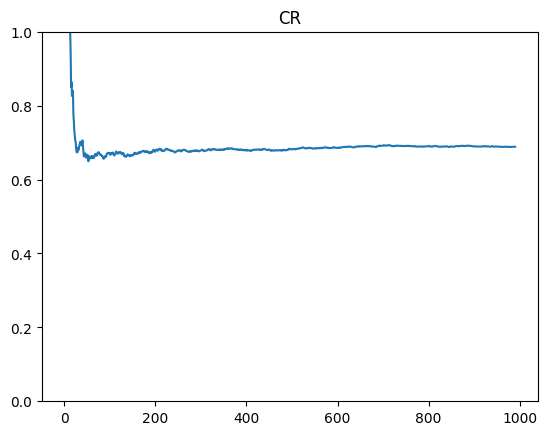

average free couriers:  1.455
average free orders:  13.289
average active routes:  18.545


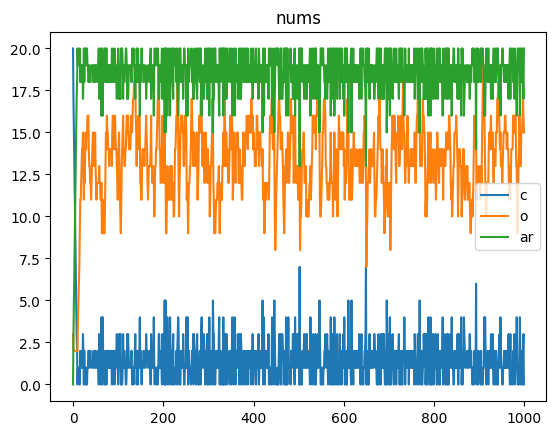

In [7]:
# dsp = NeuralDispatch(net)
dsp = Dispatch()
sim = Simulator()

all_metrics = []
for i in tqdm(range(1000)):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    state = sim.GetState()
    sim.Next(dsp(state))

plot_CR(all_metrics)
plot_counts(all_metrics)

In [8]:
# # dsp = NeuralDispatch(net)
# dsp = Dispatch()
# sim = ManualSimulator()

# all_metrics = []
# for i in tqdm(range(1000)):
#     metrics = sim.GetMetrics()
#     all_metrics.append(metrics)
#     ass = dsp(sim.GetState())
#     sim.Next(ass)

# plot_CR(all_metrics)
# plot_counts(all_metrics)

In [8]:
# model.tensors['o'].shape
model.masks['o'].shape

torch.Size([4, 10])

In [48]:
class SimulatorEnv(EnvBase):
    def __init__(self, simulator: type[Simulator], seed=None, device="cpu"):
        super().__init__(device=device, batch_size=[])

        self.load_settings()
        
        # self.simulators = [simulator(seed=i) for i in range(sub_batch_size)]
        self.simulator = simulator()
        self.encoder = GambleTripleEncoder(number_enc_dim=self.number_enc_dim, d_model=self.d_model, point_enc_dim=self.point_enc_dim)
        # self.model = ScoringInterface(net)
        # triples = [simulator.GetState() for simulator in self.simulators]
        # self.model.encode_input(triples, 0)
        self._make_specs()
        
        if seed is None:
            seed = torch.empty((), dtype=torch.long).random_().item()
        self.set_seed(seed)

    def load_settings(self):
        with open('configs/rl_settings.json') as f:
            settings = json.load(f)
        self.max_num_orders = settings['max_num_orders']
        self.max_num_couriers = settings['max_num_couriers']
        self.max_num_active_routes = settings['max_num_active_routes']

        with open('configs/network_hyperparams.json') as f:
            hyperparams = json.load(f)
        self.number_enc_dim = hyperparams['number_enc_dim']
        self.d_model = hyperparams['d_model']
        self.point_enc_dim = hyperparams['point_enc_dim']


    def make_masks(self, tensors):
        masks = {
            'o': torch.tensor([True] + [False] * (len(tensors['o']) - 1), device=device, dtype=torch.bool),
            'c': torch.tensor([True] + [False] * (len(tensors['c']) - 1), device=device, dtype=torch.bool),
            'ar': torch.tensor([True] + [False] * (len(tensors['ar']) - 1), device=device, dtype=torch.bool)
        }

        return masks
    
    def pad_tensors(self, tensors, masks, ids):
        '''
        Pads tensors to max_limits inplace
        '''
        max_limits = {
            'o': self.max_num_orders,
            'c': self.max_num_couriers,
            'ar': self.max_num_active_routes
        }
        for item_type in ['o', 'c', 'ar']:
            length = tensors[item_type].shape[0]
            tensors[item_type] = F.pad(input=tensors[item_type], pad=(0, 0, 0, max_limits[item_type] - length), mode='constant', value=0.0)
            masks[item_type] = F.pad(input=masks[item_type], pad=(0, max_limits[item_type] - length), mode='constant', value=True)
            ids[item_type] = F.pad(input=ids[item_type], pad=(0, max_limits[item_type] - length), mode='constant', value=-1)

        
    def _step(self, tensordict: TensorDictBase) -> TensorDictBase:
        '''
        tensordict['action'] - a np.array of indexes (not IDs) of couriers assigned for the given order. If there is no courier assigned -1 is provided.
        BOS-fake items are included.
        '''

        assignments = []
        assigned_o_idxs = set()
        assigned_c_idxs = set()
        for o_idx, c_idx in enumerate(tensordict['action'].numpy()):
            if c_idx != - 1 \
                and not tensordict['observation', 'masks', 'o'][o_idx] \
                and not tensordict['observation', 'masks', 'c'][c_idx] \
                and (o_idx not in assigned_o_idxs) and (c_idx not in assigned_c_idxs) \
            :
                assignment = (tensordict['observation', 'ids', 'o'][o_idx].item(), tensordict['observation', 'ids', 'c'][c_idx].item())
                assignments.append(assignment)
                assigned_o_idxs.add(o_idx)
                assigned_c_idxs.add(c_idx)

        # print(assignments)
        # print(self.simulator.GetState())
        self.simulator.Next(assignments)
        triple = self.simulator.GetState()
        tensors, ids = self.encoder(triple, 0)
        masks = self.make_masks(tensors)
        self.pad_tensors(tensors, masks, ids)

        out = TensorDict(
            {
                "next": {
                    "observation": {
                        'tensors': {
                            'o': tensors['o'],
                            'c': tensors['c'],
                            'ar': tensors['ar']     
                        },
                        'masks': {
                            'o': masks['o'],
                            'c': masks['c'],
                            'ar': masks['ar']     
                        },
                        'ids': {
                            'o': ids['o'],
                            'c': ids['c'],
                            'ar': ids['ar']
                        }
                    },
                    "reward": torch.tensor(0, dtype=torch.float32),
                    "done": torch.tensor(False, dtype=torch.bool),
                    # "reward": torch.tensor([0] * sub_batch_size, dtype=torch.float32),
                    # "done": torch.tensor([False] * sub_batch_size, dtype=torch.bool),
                }
            },
            tensordict.shape
            # batch_size=tensordict.shape[0]
        )
        # print(out['next', 'observation', 'ids', 'o'])
        return out
    
    def _reset(self, tensordict: TensorDictBase) -> TensorDictBase:
        if tensordict is None or tensordict.is_empty():
            triple = self.simulator.GetState()
            tensors, ids = self.encoder(triple, 0)
            masks = self.make_masks(tensors)
            self.pad_tensors(tensors, masks, ids)
            
            return TensorDict(
            {
                "observation": {
                    'tensors': {
                        'o': tensors['o'],
                        'c': tensors['c'],
                        'ar': tensors['ar']     
                    },
                    'masks': {
                        'o': masks['o'],
                        'c': masks['c'],
                        'ar': masks['ar']     
                    },
                    'ids': {
                        'o': ids['o'],
                        'c': ids['c'],
                        'ar': ids['ar']
                    }
                }
            },
            # batch_size=[sub_batch_size]
            batch_size=self.batch_size
        ) 
        return tensordict
    
    def _set_seed(self, seed: Optional[int]):
        rng = torch.manual_seed(seed)
        self.rng = rng

    def _make_specs(self) -> None:
        self.action_spec = DiscreteTensorSpec(
            n=self.max_num_couriers,
            dtype=torch.int,
            shape=[self.max_num_orders]
        )
        observation_spec = CompositeSpec(
            tensors = CompositeSpec(
                o = UnboundedContinuousTensorSpec(
                    shape=[self.max_num_orders, self.encoder.d_model],
                    dtype=torch.float
                ),
                c = UnboundedContinuousTensorSpec(
                    shape=[self.max_num_couriers, self.encoder.d_model],
                    dtype=torch.float
                ),
                ar = UnboundedContinuousTensorSpec(
                    shape=[self.max_num_active_routes, self.encoder.d_model],
                    dtype=torch.float
                ),
                # shape=[sub_batch_size]
            ),
            masks = CompositeSpec(
                o = DiscreteTensorSpec(
                    n=2,
                    dtype=torch.bool,
                    shape=[self.max_num_orders]
                ),
                c = DiscreteTensorSpec(
                    n=2,
                    dtype=torch.bool,
                    shape=[self.max_num_couriers]
                ),
                ar = DiscreteTensorSpec(
                    n=2,
                    dtype=torch.bool,
                    shape=[self.max_num_active_routes]
                ),
                # shape=[sub_batch_size]
            ),
            ids = CompositeSpec(
                o = UnboundedDiscreteTensorSpec(
                    dtype=torch.int,
                    shape=[self.max_num_orders]
                ),
                c = UnboundedDiscreteTensorSpec(
                    dtype=torch.int,
                    shape=[self.max_num_couriers]
                ),
                ar = UnboundedDiscreteTensorSpec(
                    dtype=torch.int,
                    shape=[self.max_num_active_routes]
                ),
                # shape=[sub_batch_size]
            ), 
            # shape=[sub_batch_size]
        )
        # if not isinstance(observation_spec, CompositeSpec):
        observation_spec = CompositeSpec(observation=observation_spec) # shape=[sub_batch_size]
            
        self.observation_spec = observation_spec
        self.reward_spec = UnboundedContinuousTensorSpec(
            # shape=[sub_batch_size],
            shape=[1],
            dtype=torch.float32,
        )
        self.done_spec = BinaryDiscreteTensorSpec(
            # n=sub_batch_size,
            # shape=[sub_batch_size],
            n=1,
            shape=[1],
            dtype=torch.bool
        )
 

In [49]:
my_env = SimulatorEnv(Simulator)

In [50]:
env = TransformedEnv(
    my_env,
    # Compose(
    #     # normalize observations
    #     # ObservationNorm(in_keys=["observation"]),
    #     # DoubleToFloat(in_keys=["observation"]),
    #     StepCounter(),
    # ),
)

In [51]:
# env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
# print("normalization constant shape:", env.transform[0].loc.shape)
print("observation_spec:", my_env.observation_spec)
print("reward_spec:", my_env.reward_spec)
print("input_spec:", my_env.input_spec)
print("action_spec (as defined by input_spec):", my_env.action_spec)

observation_spec: CompositeSpec(
    observation: CompositeSpec(
        tensors: CompositeSpec(
            o: UnboundedContinuousTensorSpec(
                 shape=torch.Size([100, 512]), space=None, device=cpu, dtype=torch.float32, domain=continuous),
            c: UnboundedContinuousTensorSpec(
                 shape=torch.Size([100, 512]), space=None, device=cpu, dtype=torch.float32, domain=continuous),
            ar: UnboundedContinuousTensorSpec(
                 shape=torch.Size([100, 512]), space=None, device=cpu, dtype=torch.float32, domain=continuous), device=cpu, shape=torch.Size([])),
        masks: CompositeSpec(
            o: DiscreteTensorSpec(
                 shape=torch.Size([100]), space=DiscreteBox(n=2), device=cpu, dtype=torch.bool, domain=discrete),
            c: DiscreteTensorSpec(
                 shape=torch.Size([100]), space=DiscreteBox(n=2), device=cpu, dtype=torch.bool, domain=discrete),
            ar: DiscreteTensorSpec(
                 shape=torch.

In [52]:
check_env_specs(my_env)

check_env_specs succeeded!


In [53]:
rollout = my_env.rollout(10)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)
rollout.batch_size

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 100]), device=cpu, dtype=torch.int32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: TensorDict(
                    fields={
                        ids: TensorDict(
                            fields={
                                ar: Tensor(shape=torch.Size([10, 100]), device=cpu, dtype=torch.int32, is_shared=False),
                                c: Tensor(shape=torch.Size([10, 100]), device=cpu, dtype=torch.int32, is_shared=False),
                                o: Tensor(shape=torch.Size([10, 100]), device=cpu, dtype=torch.int32, is_shared=False)},
                            batch_size=torch.Size([10]),
                            device=c

torch.Size([10])

In [54]:
module = TensorDictModule(
    net, in_keys=[('observation', 'tensors'), ('observation', 'masks')], out_keys=['logits', 'values']
)

In [17]:
# td = my_env.reset()
# net(td['observation', 'tensors'].to_dict(), td['observation', 'masks'].to_dict())
# td['observation', 'tensors'].to_dict()

In [55]:
print("Running policy:", module(my_env.reset()).shape)
# env.reset()

Running policy: torch.Size([])


In [22]:
# for i in [0, 1, 2, 3]:
#     print(my_env.simulators[i].GetMetrics())
#     print('-'* 50)


In [56]:
# from tensordict.nn.distributions import Categorical
from torch.distributions.categorical import Categorical
policy_module_actor = ProbabilisticActor(
    module=module,
    in_keys=["logits"],
    distribution_class=Categorical,
    # distribution_kwargs={
    #     "n": env.action_spec.space.n,
    # },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

In [57]:
class LogPolicyAvg(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, mask):
        assert (len(input.shape) == 2 and len(mask.shape) == 2) or (len(input.shape) == 1 and len(mask.shape) == 1), 'dims should be [bs, ord] or [ord]'

        sums = torch.sum(torch.where(mask, input, 0), dim=-1)
        nums = torch.sum(torch.where(mask, 1, 0), dim=-1)

        return torch.where(nums > 0, sums / nums, 0)

In [58]:
from tensordict.nn import TensorDictModule, TensorDictSequential
final_module = TensorDictSequential(
    policy_module_actor,
    TensorDictModule(LogPolicyAvg(), in_keys=['sample_log_prob', ('observation', 'masks', 'o')], out_keys=['sample_log_prob']),
)


In [40]:
# value_module = ValueOperator(
#     module=net,
#     in_keys=[('observation', 'tensors'), ('observation', 'masks')], 
#     out_keys=['logits', 'values']
# )

In [59]:
collector = SyncDataCollector(
    my_env,
    policy_module_actor,
    frames_per_batch=1,
    total_frames=5,
    split_trajs=False,
    device=device,
)

In [60]:
for i, c in enumerate(collector):
    if i == 1:
        break
c

IndexError: index 100 is out of bounds for dimension 0 with size 100

In [76]:
from torchrl.data import ReplayBuffer, LazyTensorStorage
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
    batch_size=sub_batch_size
)

In [77]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=module, average_gae=True, value_key='values'
)

loss_module = ClipPPOLoss(
    actor=policy_module_actor,
    critic=final_module,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr=3e-4)

In [78]:
for i, c in enumerate(collector):
    if i == 5:
        break
    advantage_module(c)
    data_view = c.reshape(-1)
    replay_buffer.extend(data_view.cpu())

subdata = replay_buffer.sample()
# loss_vals = loss_module(subdata)
# loss_value = (
#     loss_vals["loss_objective"]
#     + loss_vals["loss_critic"]
#     + loss_vals["loss_entropy"]
# )


In [79]:
subdata.flatten_keys()

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        advantage: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        collector.traj_ids: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        logits: Tensor(shape=torch.Size([4, 1, 22]), device=cpu, dtype=torch.float32, is_shared=False),
        next.done: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next.observation.ids.ar: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.int32, is_shared=False),
        next.observation.ids.c: Tensor(shape=torch.Size([4, 21]), device=cpu, dtype=torch.int32, is_shared=False),
        next.observation.ids.o: Tensor(shape=torch.Size([4, 1]), device=cpu, dtype=torch.int32, is_shared=False),
        next.observation

In [80]:
loss_vals = loss_module(subdata)

RuntimeError: advantage.shape and log_weight.shape do not match (got torch.Size([4, 1]) and torch.Size([4, 1, 1]))

In [ ]:
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()
    break

## Testing area

In [19]:
bs = 2

class TestEnv(EnvBase):
    def __init__(self, seed=None, device="cpu"):
        super().__init__(device=device, batch_size=[bs])
        self._make_specs()
        
        if seed is None:
            seed = torch.empty((), dtype=torch.long).random_().item()
        self.set_seed(seed)
        
    def _step(self, tensordict: TensorDictBase) -> TensorDictBase:
        '''
        tensordict['action'] - a np.array of indexes of couriers assigned for the given order. If there is no courier assigned -1 is provided.
        '''
        print('next')
        out = TensorDict(
            {
                "next": {
                    "observation": TensorDict({
                        'a': torch.tensor([[-1, -2], [-4, -5]], dtype=torch.float),
                        'b': torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float),
                        },
                        batch_size=[bs]
                    ),
                    "reward": torch.tensor([0] * bs, dtype=torch.float32),
                    "done": torch.tensor([False] * bs, dtype=torch.bool),
                }
            },
            batch_size=[bs]
        )
        return out
    
    def _reset(self, tensordict: TensorDictBase) -> TensorDictBase:
        if tensordict is None or tensordict.is_empty():
            return TensorDict(
            {
                "observation": TensorDict({
                        'a': torch.tensor([[-1, -2], [-4, -5]], dtype=torch.float),
                        'b': torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float),
                        },
                        batch_size=[bs]
                    ),
            },
            batch_size=[bs]
        ) 
        return tensordict
    
    def _set_seed(self, seed: Optional[int]):
        rng = torch.manual_seed(seed)
        self.rng = rng

    def _make_specs(self) -> None:
        self.action_spec = UnboundedDiscreteTensorSpec(
            dtype=torch.int,
            shape=[bs]
            # shape=(1,)
            # shape=(self.model.tensors['o'].shape[0],)
        )
        observation_spec = CompositeSpec(
            a = UnboundedContinuousTensorSpec(
                dtype=torch.float32,
                shape=[bs]
            ),
            b = UnboundedContinuousTensorSpec(
                dtype=torch.float32,
                shape=[bs]
            ),
            shape=[bs]
        )
        # if not isinstance(observation_spec, CompositeSpec):
        observation_spec = CompositeSpec(observation=observation_spec, shape=[bs])
            
        self.observation_spec = observation_spec
        self.reward_spec = UnboundedContinuousTensorSpec(
            shape=[bs],
            dtype=torch.float32,
        )
        self.done_spec = BinaryDiscreteTensorSpec(
            bs,
            shape=[bs]
        )
 

In [20]:
env = TransformedEnv(
    TestEnv(),
    # Compose(
    #     # normalize observations
    #     # ObservationNorm(in_keys=["observation"]),
    #     # DoubleToFloat(in_keys=["observation"]),
    #     StepCounter(),
    # ),
)

In [21]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

check_env_specs(env)

observation_spec: CompositeSpec(
    observation: CompositeSpec(
        a: UnboundedContinuousTensorSpec(
             shape=torch.Size([2, 3]), space=None, device=cpu, dtype=torch.float32, domain=continuous),
        b: UnboundedContinuousTensorSpec(
             shape=torch.Size([2, 3]), space=None, device=cpu, dtype=torch.float32, domain=continuous), device=cpu, shape=torch.Size([2, 3])), device=cpu, shape=torch.Size([2]))
reward_spec: UnboundedContinuousTensorSpec(
     shape=torch.Size([2]), space=None, device=cpu, dtype=torch.float32, domain=continuous)
input_spec: CompositeSpec(
    action: UnboundedDiscreteTensorSpec(
         shape=torch.Size([2]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, contiguous=True)), device=cpu, dtype=torch.int32, domain=continuous), device=cpu, shape=torch.Size([2]))
action_spec (as defined by input_spec): UnboundedDis

AssertionError: The dtypes of the real and fake tensordict don't match for key next.done. Got fake=torch.int64 and real=torch.bool.

In [89]:
fake = env.fake_tensordict().flatten_keys(".")
print(fake)

real_tensordict = env.rollout(3, return_contiguous=True).flatten_keys(".")
print(real_tensordict)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int32, is_shared=False),
        done: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, is_shared=False),
        next.done: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, is_shared=False),
        next.observation.a: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        next.observation.b: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        next.reward: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.a: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.b: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([2]),
    device=cpu,
    is_shared=F

In [91]:
fake_tensordict = fake.unsqueeze(real_tensordict.batch_dims - 1).expand(*real_tensordict.shape).to_tensordict()

In [93]:
# real_tensordict.apply(lambda x: torch.zeros_like(x)) == fake_tensordict.apply(lambda x: torch.zeros_like(x))
# fake_tensordict
fake_tensordict

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.int32, is_shared=False),
        done: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.int64, is_shared=False),
        next.done: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.int64, is_shared=False),
        next.observation.a: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        next.observation.b: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        next.reward: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.a: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        observation.b: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([2, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([2, 3]),
 

In [131]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.f1 = nn.Linear(3, 5)
        self.f2 = nn.Linear(3, 5)

        self.last = nn.Linear(5, 2)
    
    def forward(self, x, y):
        x = self.f1(x)
        y = self.f2(y)

        return self.last(x - y)

In [137]:
x = torch.tensor([[1, 2, 3]], dtype=torch.float)
y = torch.tensor([[1, 2, 3]], dtype=torch.float)
n = Net()
n(x, y)

tensor([[-1.7460, -0.8222]], grad_fn=<AddmmBackward0>)

In [138]:
policy_module = TensorDictModule(
    n, in_keys=[('inp', "x"), ('inp', "y")], out_keys=["out"]
)

In [146]:
# policy_module(x=x, y=y)
inp = TensorDict(
    {
        'inp': TensorDict({
            'x': x,
            'y': y,
        }, batch_size=())
    },
    batch_size=(1, 3)
)

In [140]:
out = policy_module(inp)

In [23]:
out['out']

tensor([1.9481, 0.0790], grad_fn=<AddBackward0>)

In [147]:
inp.shape

torch.Size([1, 3])